**Morphology**: A tool for extracting image components that are useful in the representation and description of region shape, such as boundaries, skeletons, and the convex hull.

**Set theory**: The branch of mathematics which deals with the formal properties of sets as units (without regard to the nature of their individual constituents) and the expression of other branches of mathematics in terms of sets.

## Introduction

This topic is best started out with an example. Let's say you've taken some images on a TEM microscope of a fresh batch of nanoparticles. You want to use this to get some information about the size of your nanoparticles. You have access to the resolution of the microscope, and you have calculated the diameter of the size of a few nanoparticles by hand. But shouldn't there be a way to automate this process? You've tried a few simple manipulations in ImageJ by applying an intensity threshold to create a binary image, but you can tell that some objects in the image are noise, while other particles overlap. Both of these create inaccuracies in your size estimates.

How do you approach this problem? This is where the *morphology* toolset comes in handy, and will hopefully aid us in being able to tackle this problem and similar problems.

## Logical Operators

Most of the techniques used in this unit will deal with *binary images*, or images that have pixels that can only take the valueu 0 and 1 (black and white images). Binary image are useful because they allow us to use logical operators. Here's a few examples using some tools from `scikit-image`:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology.selem import square, disk, star, diamond, rectangle
from skimage.util import pad

In [2]:
elem1 = np.zeros((31, 42))
elem2 = np.zeros((31, 42))
elem1[:, 0:31] = disk(15)
elem2[:, 11:] = disk(15)
#st_elem = star(10)
#dif_elem = d_elem
int_elem = np.logical_and(elem1, elem2)
un_elem = np.logical_or(elem1, elem2)

n_elem1 = 1 - elem1
n_elem2 = 1 - elem2

xor_elem = np.logical_xor(elem1, elem2)
cxor_elem = 1 - np.logical_xor(elem1, elem2)

Text(0.5, 1.0, 'XOR Complement')

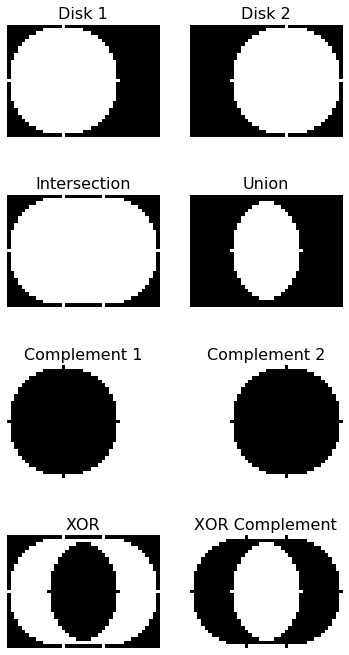

In [3]:
fig, ax = plt.subplots(4, 2, figsize=(6, 12))

ax[0, 0].imshow(elem1, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Disk 1', fontsize=16)

ax[0, 1].imshow(elem2, cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('Disk 2', fontsize=16)

ax[1, 0].imshow(un_elem, cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('Intersection', fontsize=16)

ax[1, 1].imshow(int_elem, cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('Union', fontsize=16)

ax[2, 0].imshow(n_elem1, cmap='gray')
ax[2, 0].axis('off')
ax[2, 0].set_title('Complement 1', fontsize=16)

ax[2, 1].imshow(n_elem2, cmap='gray')
ax[2, 1].axis('off')
ax[2, 1].set_title('Complement 2', fontsize=16)

ax[3, 0].imshow(xor_elem, cmap='gray')
ax[3, 0].axis('off')
ax[3, 0].set_title('XOR', fontsize=16)

ax[3, 1].imshow(cxor_elem, cmap='gray')
ax[3, 1].axis('off')
ax[3, 1].set_title('XOR Complement', fontsize=16)

Some other useful functions that you may need for morphological applications are the **reflection** of an image:

In [4]:
elem = np.zeros((63, 110))
elem[:, 10:73] = diamond(31)

Text(0.5, 1.0, 'Disk 2')

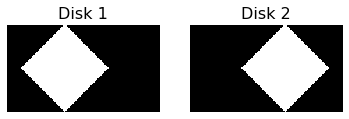

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(6, 9))

ax[0].imshow(elem, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Disk 1', fontsize=16)

#Note how you can implement the reflection just by using indices.
ax[1].imshow(elem[:, ::-1], cmap='gray')
ax[1].axis('off')
ax[1].set_title('Disk 2', fontsize=16)

## Dilation and Erosion

Two of the most basic morphological operations are *dilation* and *erosion*. The words are fairly descriptive: can you guess what these two functions do to a binary image?

In [2]:
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate

In [7]:
im = pad(star(31), 5)
im_er = erode(im, selem=disk(5))
im_dil = dilate(im, selem=disk(5))

Text(0.5, 1.0, 'Dilation')

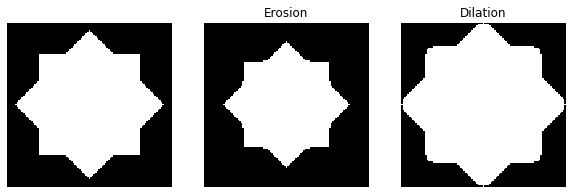

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))



ax[0].imshow(im, cmap='gray')
ax[0].axis('off')

ax[1].imshow(im_er, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Erosion')

ax[2].imshow(im_dil, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Dilation')

Mathematically, the dilation of A by B is expressed as:

$$A \oplus B = \{ z | (\hat{B})_z  \cap A \neq \emptyset \}$$

This can be read as all elements at location z defined by the intersection of A and the reflection of B shifted z units. Thus, the dilation is the set of all displacements, z, such that B and A overlap by at least one element. You can conceptualize this by sliding the smaller structing element around the image of interest. As long as B and A overlap by at least one unit.

Similarly, erosion of A by B is expressed as:

$$A \ominus B = \{ z | (B)_z \subseteq A \} $$

Or, in words, the erosion of A by B is the set of all points z such that B, translated by z, is contained in A. 

B is often called the **structuring element** and is defined as **selem** in `scikit-image`.

One of the most common uses of erosion is for the elimination of irrelevant detail (in terms of size) from a binary image. If we want to eliminate all shapes except large ones, an erosion step is the tool to use. 

In [9]:
im = np.tile(pad(star(25), 45), (5, 5))
test = np.random.random(im.shape) > 0.99
test = dilate(test, disk(2))
im = im | test

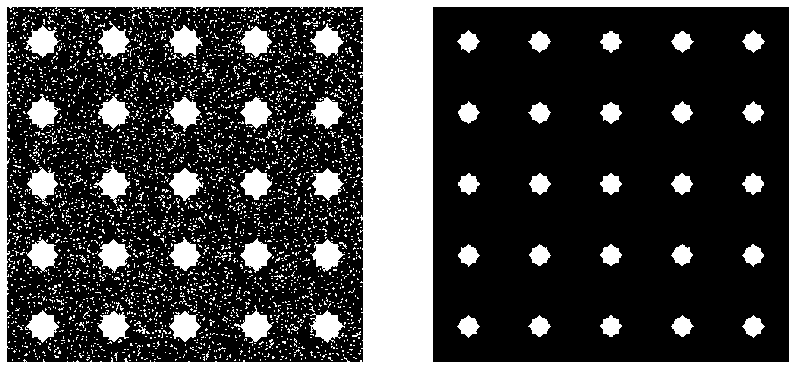

In [10]:
im_e = erode(im, disk(8))

fig, axes = plt.subplots(ncols=2, figsize=(14,7))

for ax in axes:
    ax.axis('off')

axes[0].imshow(im, cmap='gray')
axes[1].imshow(im_e, cmap='gray')

## Opening and Closing

You may have noticed that, yes, you can use erosions to remove small objects and dilations to connect peninsulas, but now the size isn't accurately represented. Eroded objects are smaller, dilated objects are larger. The solution is to sequentially perform dilations and erosions. For instance, erode small objects by performing an erosion, then restore the surviving objects using a dilation of similar magnitude. These operations have their own mathematical representations:

The opening of A by B is defined as:

$$A \circ B = (A \ominus B) \oplus B $$

And the closing of A by B is defined as:

$$A \bullet B = (A \oplus B) \ominus B $$

In [3]:
from skimage.morphology import opening, closing

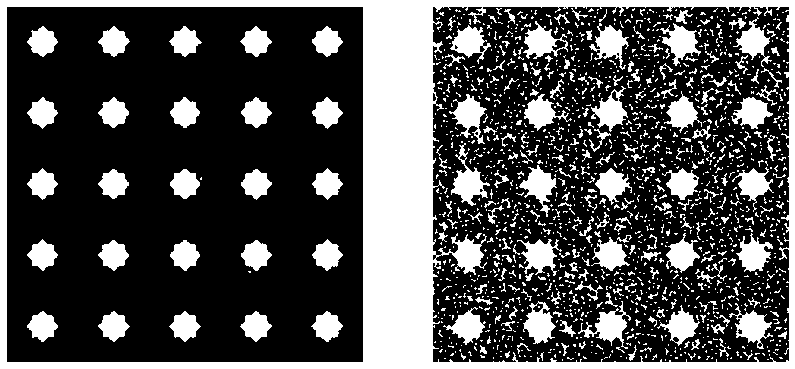

In [12]:
im_o = opening(im, disk(3))
im_c = closing(im, disk(3))

fig, axes = plt.subplots(ncols=2, figsize=(14,7))

for ax in axes:
    ax.axis('off')

axes[0].imshow(im_o, cmap='gray')
axes[1].imshow(im_c, cmap='gray')

## Hit or Miss Transformation

The hit or miss transformation takes advantage of some of the tools defined above to identify shapes in an image.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import pad
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology.selem import square, disk, star, diamond, rectangle

In [14]:
X = rectangle(40, 100)
Y = square(80)
Z = square(110)

Xp = pad(X, 70)
Yp = pad(Y, 20)
Zp = pad(Z, 5)

Wmx = 1 - Xp
Wmy = 1 - Yp
Wmz = 1 - Zp

In [15]:
A = np.concatenate((np.concatenate((Yp, Zp), axis=1), Xp), axis=0)
A_er = erode(A, Y)
Ac = 1 - A
Ac_er = erode(Ac, Wmy)
loc = np.logical_and(A_er, Ac_er)

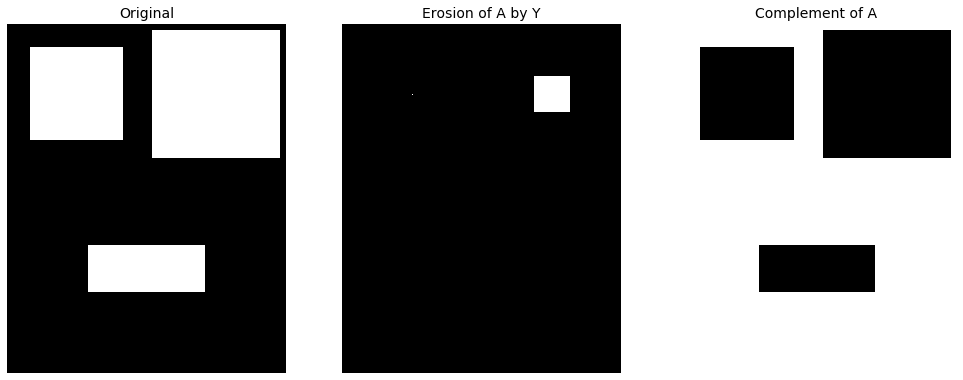

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 8))
titles = ['Original', 'Erosion of A by Y', 'Complement of A']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    

axes[0].imshow(A, cmap='gray')
axes[1].imshow(A_er, cmap='gray')
axes[2].imshow(Ac, cmap='gray')

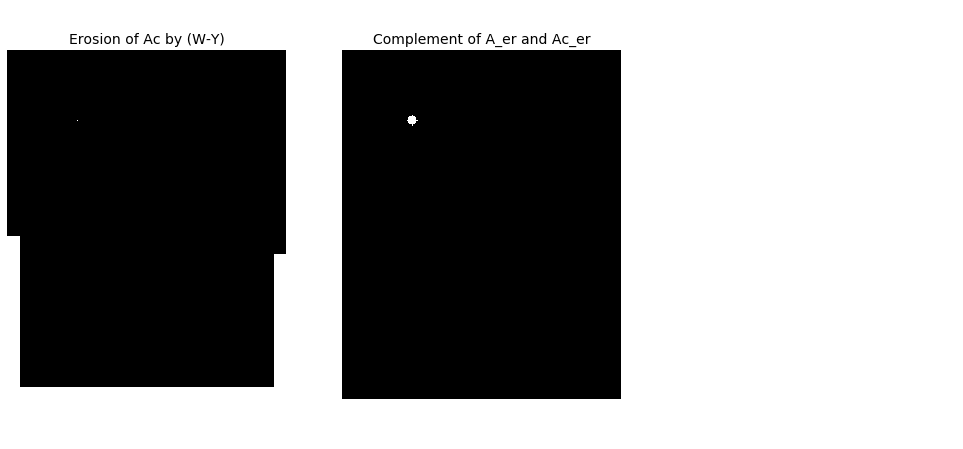

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 8))
titles = ['Erosion of Ac by (W-Y)', 'Complement of A_er and Ac_er', '']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    

axes[0].imshow(Ac_er, cmap='gray')
axes[1].imshow(dilate(loc, disk(4)), cmap='gray')
#axes[2].imshow(Ac_er, cmap='gray')

# Basic Morphological Algorithms

When dealing with binary images, the principle application of morphology is extracting image components that are useful in the representation and description of shape. We are going to consider some algorithms to extract boundaries, connected components, the convex hull, and the skeleton of a region. We will also develop methods (for region filling, thinning, thickening, and pruning) that are used frequently in conjunction with these algorithms and pre- and postprocessing steps. 

## Boundary Extraction

The boundary of a set A can be obtained by eroding A by B (a structuring element) and then taking the difference of A and its erosion:

$$\beta(A) = A - (A \ominus B) $$

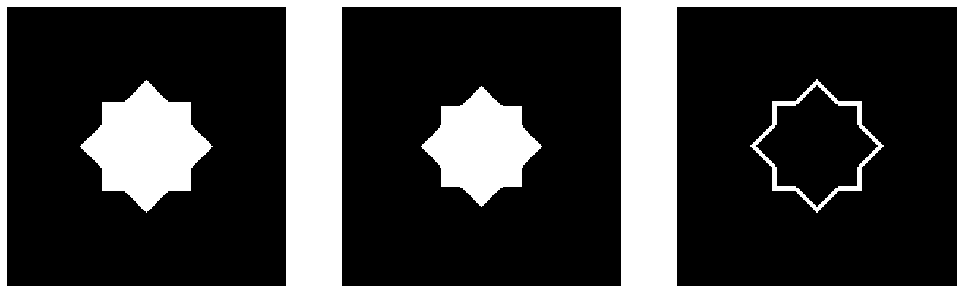

In [18]:
A = pad(star(30), 50)

fig, axes = plt.subplots(ncols=3, figsize=(17, 6))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(A, cmap='gray')
axes[1].imshow(erode(A, disk(3)), cmap='gray')
axes[2].imshow(A - erode(A, disk(3)), cmap='gray')

## Region Filling



In [5]:
from scipy.ndimage.morphology import binary_fill_holes as fill_holes

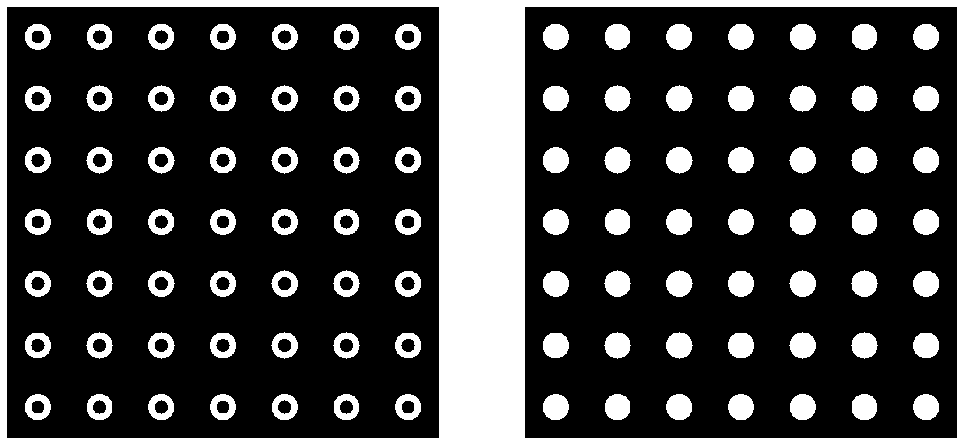

In [20]:
A = pad(disk(30), 40)

im = np.tile(A - erode(A, disk(15)), (7, 7))
im_filled = fill_holes(im, disk(3))

fig, axes = plt.subplots(ncols=2, figsize=(17, 8))

for ax in axes:
    ax.axis('off')
    

axes[0].imshow(im, cmap='gray')
#axes[0].imshow(opening(1 - im, disk(20)), cmap='gray')
axes[1].imshow(im_filled, cmap='gray')

## Convex Hull

A set A is said to be convex if the straight line segment joining any two points in A lies entirely within A. The convex hull H of an artibrary set S is the smallest convex set containing S. The set difference H - S is called the convex deficiency of S. The convex hull and convex deficiency are useful in object description.

Don't worry about the math on this one-- it involves the hit-or-miss algorithm using the shapes below

In [21]:
# B1 = np.array([[0,1,1],[0,0,1],[0,1,1]])
# B2 = np.array([[0,0,0],[1,0,1],[1,1,1]]) 
# B3 = np.array([[1,1,0],[1,0,0],[1,1,0]]) 
# B4 = np.array([[1,1,1],[1,0,1],[0,0,0]]) 

# fig, axes = plt.subplots(ncols=4, figsize=(17, 8))

# for ax in axes:
#     ax.axis('off')
    

# axes[0].imshow(B1, cmap='gray')
# axes[1].imshow(B2, cmap='gray')
# axes[2].imshow(B3, cmap='gray')
# axes[3].imshow(B4, cmap='gray')

In [6]:
from skimage.morphology import convex_hull_image
from skimage import data
from skimage.util import invert

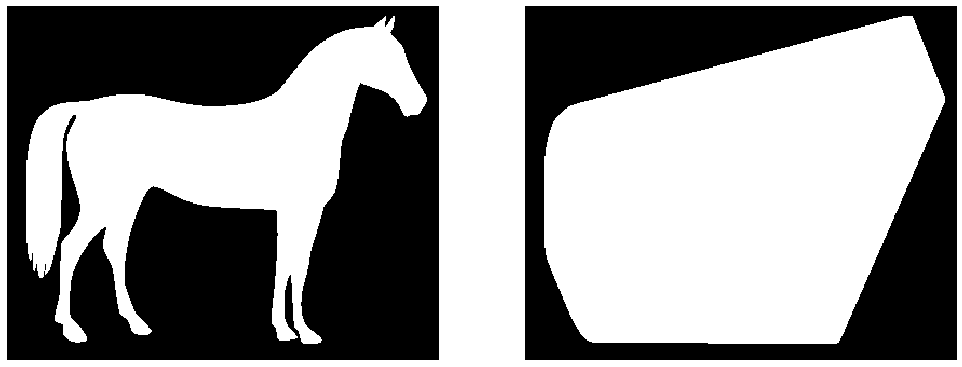

In [23]:
im = invert(data.horse())
im_conv = convex_hull_image(im)

fig, axes = plt.subplots(ncols=2, figsize=(17, 8))

for ax in axes:
    ax.axis('off')
    

axes[0].imshow(im, cmap='gray')
axes[1].imshow(im_conv, cmap='gray')

# Thinning

In [7]:
from scipy.ndimage.morphology import binary_hit_or_miss as hit_miss
from skimage.morphology import thin

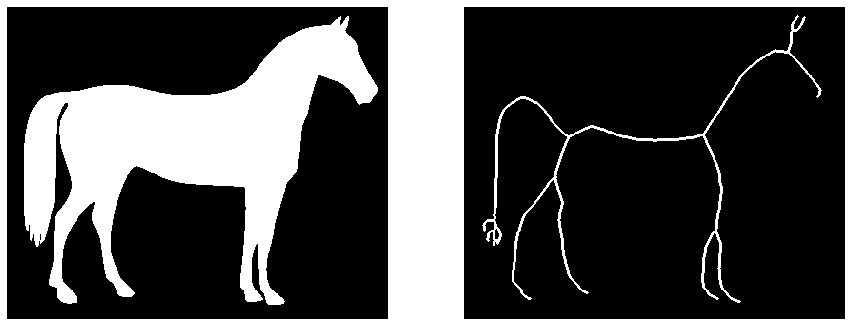

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 9))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(dilate(thin(im), disk(1)), cmap='gray')
#axes[2].imshow(A - erode(A, disk(3)), cmap='gray')

In [27]:
# B = {}
# B[0] = np.array([[0,0,0],[1,0,1],[0,0,0]])
# B[1] = np.array([[1,0,0],[0,0,0],[0,0,1]])
# B[2] = np.array([[0,1,0],[0,0,0],[0,1,0]])
# B[3] = np.array([[0,0,1],[0,0,0],[1,0,0]])
# z = np.zeros((3,3))
# im = im.astype(int)
# im_thin = np.copy(im)

# fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(12, 20))
# axes = [item for sublist in axes for item in sublist]


# for j in range(5):
#     for i in range(4):
#         axes[j*4 + i].axis('off')
#         axes[j*4 + i].imshow(dilate(im_thin, disk(5)), cmap='gray')
#         im_thin = hit_miss(im_thin, B[i], z)

## Thickening

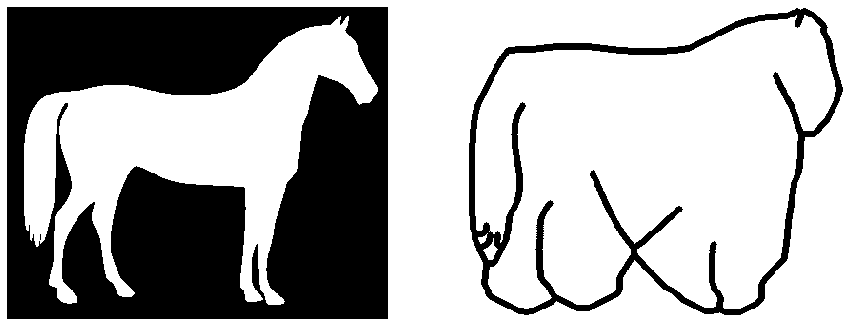

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 9))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(1-dilate(thin(1-im), disk(3)), cmap='gray')
#axes[2].imshow(A - erode(A, disk(3)), cmap='gray')

## Skeletonization

In [29]:
from skimage.morphology import skeletonize

In [ ]:
im = dilate(np.pad(rectangle(50, 60), 30), star(10))
#im_thin = dilate(thin(im), disk(1))
im_thin = thin(im)
#im_skel = dilate(skeletonize(im, method='zhang'), disk(1))
im_skel = skeletonize(im, method='zhang')

plt.imshow(im_thin, cmap='gray')

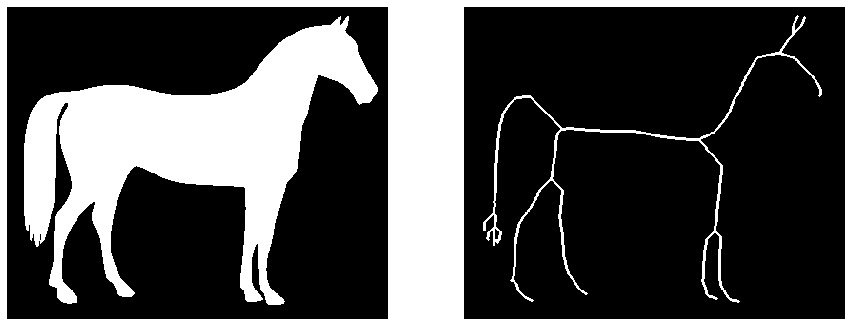

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 9))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(dilate(skeletonize(im), disk(1)), cmap='gray')

## Gray-Scale Versions

There are gray-scale equivalents to some of the binary operations we performed above (dilation, erosion, opening, closing). 

Opening and closing have a simple geometric interpretation. Suppose that we view an image function f(x,y) in a 3D perspective (intensities being expressed as height). The image now appears as a surface. Suppose that we open f by a spherical structuring element b, viewing this element as a rolling "ball". The mechanics of opening f by b may be interpreted geometrically as the process of pushing the ball against the underside of the surface. Closing would be the exact same process, but from the top-side.

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [9]:
from skimage.morphology import opening as gs_opening
from skimage.morphology import closing as gs_closing
from skimage.morphology import ball

In [35]:
x = np.linspace(0, 100, 1001)
noise = lowess(np.random.random(1001), x, 1./200)
noise = noise[:, 1]
y = np.sin(0.5*x) + 1 + noise
im = np.tile(y, (100,1))
selem = disk(5)


im_close = gs_closing(im, selem)
y_close = im_close[5, :]
im_open = gs_opening(im, selem)
y_open = im_open[5, :]
im_oc = gs_closing(gs_opening(im, selem), selem)
y_oc = im_oc[5, :]

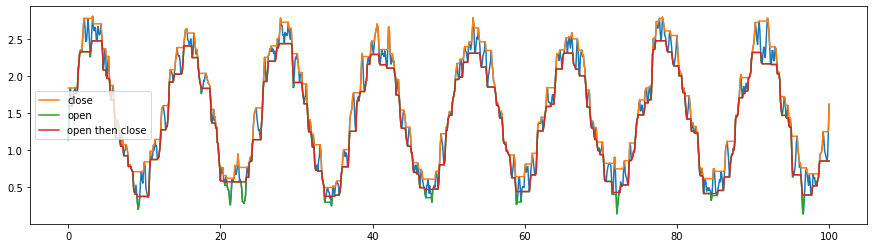

In [36]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(x, y)
ax.plot(x, y_close, label='close')
ax.plot(x, y_open, label='open')
ax.plot(x, y_oc, label='open then close')

ax.legend()

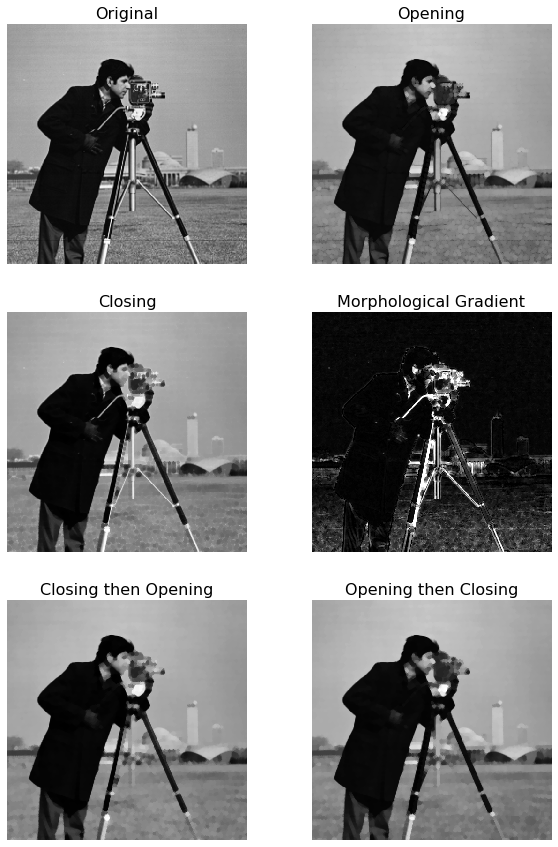

In [37]:
im = data.camera()
selem = disk(3)

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10,15))
axes = [item for sublist in axes for item in sublist]
titles = ['Original', 'Opening', 'Closing', 'Morphological Gradient', 'Closing then Opening', 'Opening then Closing']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title, fontsize=16)

axes[0].imshow(im, cmap='gray')
axes[1].imshow(gs_opening(im, selem), cmap='gray')
axes[2].imshow(gs_closing(im, selem), cmap='gray')
axes[3].imshow(gs_closing(im, selem) - gs_opening(im, selem), cmap='gray', vmax=100)
axes[4].imshow(gs_opening(gs_closing(im, selem), selem), cmap='gray')
axes[5].imshow(gs_closing(gs_opening(im, selem), selem), cmap='gray')

**Morphological smoothing**: Grayscale opening and closing give us another tool to perform smoothing on an image. 

**Morphological gradient**: The morphological gradient (the difference of the opening and the closing) highlight sharp gray-level transitions, another potential tool to base an edge detector off of. As opposed to other gradient methods, gradients obtained this way depend less on edge directionality.

## Top-hat transformation

The top-hat transformation is defined as:

$$h = f - (f \circ b) $$

This transformation can be used to remove objects that are large from an image.

In [10]:
from skimage.morphology import white_tophat
import urllib

In [74]:
im

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:

#im = data.camera()
im = plt.imread(urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/7/74/Cosmos_original.jpg'), format='jpeg')
im = im[:,:,0]

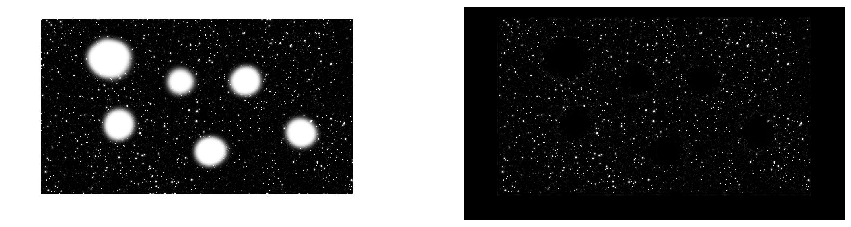

In [70]:
selem = disk(6)

fig, axes = plt.subplots(ncols=2, figsize=(15, 9))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im, cmap='gray')
axes[1].imshow(white_tophat(im, selem=selem), cmap='gray')

## Textural Segmentation

Here's one I think is WAY cool. The image below shows particles of two different sizes. The particles of the left are smaller than those on the right. The objective is to find the boundary between the two regions.

The first step is to close the input image by using successively larger structuring elements. When the size of the structuring element corresponds to that of the particles, they are removed from the image. Next we perform an opening of the image using a structuring element large in comparison to the gaps between the large particles. This makes a solid mush of grays where the large particles are. We can threshold this image to visualize the boundary.

In [12]:
from skimage.util import img_as_ubyte

In [13]:
im2 = img_as_ubyte(plt.imread('https://github.com/uw-cheme599/uw-cheme599.github.io/raw/master/Wi20_content/textural_segmentation.png'))
im2 = im2[:, :, 0]

In [14]:
im2 = gs_opening(im2, disk(1))
im2_close = gs_closing(im2, disk(55))
im2_co = gs_opening(im2_close, disk(90))

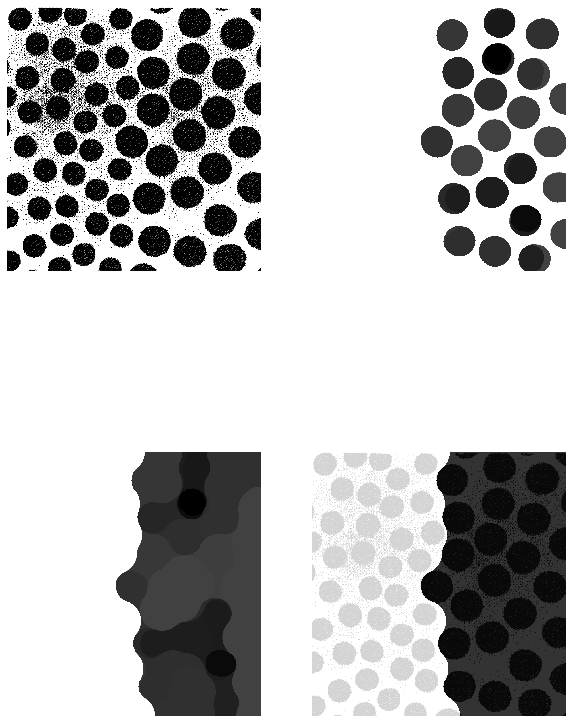

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,15))
axes = [item for sublist in axes for item in sublist]


for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im2, cmap='gray')
axes[1].imshow(im2_close, cmap='gray')
axes[2].imshow(im2_co, cmap='gray')

axes[3].imshow(im2, alpha=0.8, cmap='gray')
axes[3].imshow(im2_co > 200, cmap='gray', alpha=0.8)
#axes[2].imshow(A - erode(A, disk(3)), cmap='gray')

## Granulometry

Granulometry is a field that deals primarily with determining the size distribution of particles in an image. Opening and closing give us a tool that we can use to do this. The image below shows an image with particles of different sizes. The objects not only are overlapping, but they are also too cluttered to enable detection of individual particles. Because the particles are lighter than the background, the following algorithm can be used to determine the size distribution:

Opening operations with structuring elements of increasing size are performed on the original image. The difference between the original image and its opening is computed after each pass. At the end of the process, these differences are normalized and then used to construct a histogram of particle size distribution.

In [43]:
from skimage.transform import rescale

In [44]:
im3 = img_as_ubyte(plt.imread('particles.png'))
im3 = im3[:, :, 0]
im3 = rescale(im3, 0.3)
#plt.imshow(gs_opening(im3, disk(20)), cmap='gray')

(-0.5, 353.5, 262.5, -0.5)

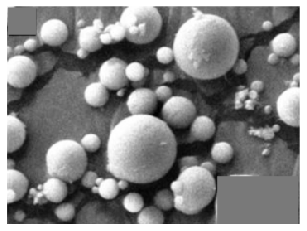

In [45]:
plt.imshow(im3, cmap='gray')
plt.axis('off')

In [46]:
sizes = np.linspace(5, 100, 20).astype(int)

In [47]:
im3_open = {}
for i in sizes:
    im3_open[i] = gs_opening(im3, disk(i))
    print(i)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


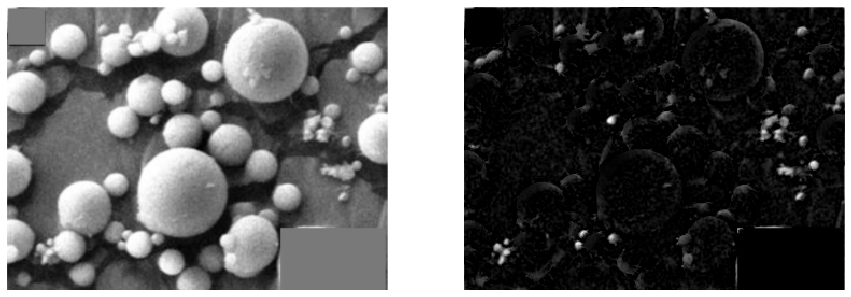

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 9))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(im3, cmap='gray')
axes[1].imshow(im3-im3_open[5], cmap='gray')

In [49]:
hist = [0]*len(sizes)

j = 0
for i in sizes:
    print(np.sum(im3-im3_open[i]))
    hist[j] = np.sum(im3-im3_open[i])
    j += 1

2407.965672995814
6718.63928270114
11757.437470383555
15366.665769400757
19126.32565605887
21406.681141166668
22839.50934586396
24621.999680458033
27978.36934473306
29632.27356033931
31688.71828759605
32904.57785533346
33291.07540469004
33529.23343708839
33685.45901541257
34117.396493767556
34531.63895326072
35650.35328749708
35881.65148291923
36053.29945128706


In [50]:
hist = np.array(hist)

In [51]:
hist_norm = np.diff(hist)/np.array(sizes[1:]**2)

<BarContainer object of 19 artists>

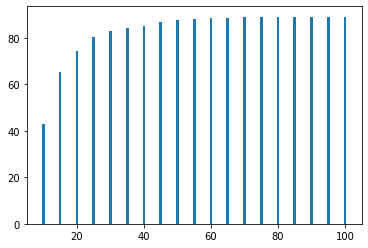

In [52]:
plt.bar(sizes[1:], np.cumsum(hist_norm))